<a href="https://colab.research.google.com/github/madonnaojorin/Intro_to_MathBio/blob/main/Parameter_Estimation_Nonlinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Text(0, 0.5, 'Population')

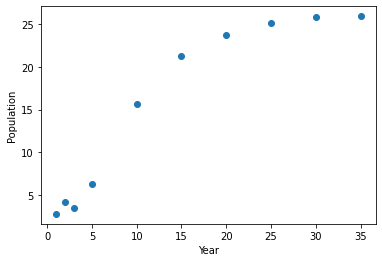

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

Population = [2.8,4.2,3.5,6.3,15.7,21.3,23.7,25.1,25.8,25.9]
Year = [1,2,3,5,10,15,20,25,30,35]
plt.scatter(Year, Population)
plt.xlabel('Year')
plt.ylabel('Population')

One common non-linear model is used in biology to model the logistic growth of a population.

The model can be written as
$$\frac{dP}{dt}=rP\left(1-\frac{P}{K}\right)$$
where $P$ is population size (the dependent variable) and $t$ is time (the independent variable). 

The closed-form solution to the corresponding initial-value problem is given by
$$P(t)=\frac{P_0Ke^{rt}}{(K-P_0)+P_0e^{rt}}$$


In [14]:
from scipy.optimize import curve_fit

def logistic(t, P0 ,K, r):
    y = (P0*K*np.exp(r*t))/((K-P0)+P0*np.exp(r*t))
    return (y)

p0 = [min(Population), max(Population), 0.3] # this is an mandatory initial guess

popt, pcov = curve_fit(logistic, Year, Population, p0, method='dogbox')
popt

array([ 2.11585892, 25.50289437,  0.2750776 ])

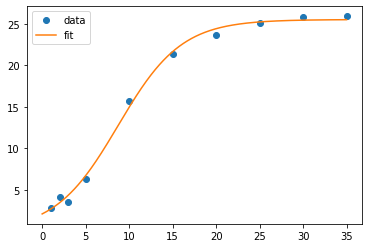

In [12]:
x = np.linspace(0, 35, 1000)
y = logistic(x, *popt)

plt.plot(Year, Population, 'o', label='data')
plt.plot(x,y, label='fit')
plt.legend(loc='best')

#Goal of Gradient Descent — First Steps

In [16]:
def eval_logistic(coeffs, t):
  y = (coeffs[0]*coeffs[1]*np.exp(coeffs[2]*t))/((coeffs[1]-coeffs[0])+coeffs[0]*np.exp(coeffs[2]*t))
  return y

In [17]:
coeffs = [1.5,20,0.2]

In [18]:
x=10
eval_logistic(coeffs, x)

7.4930637834813725

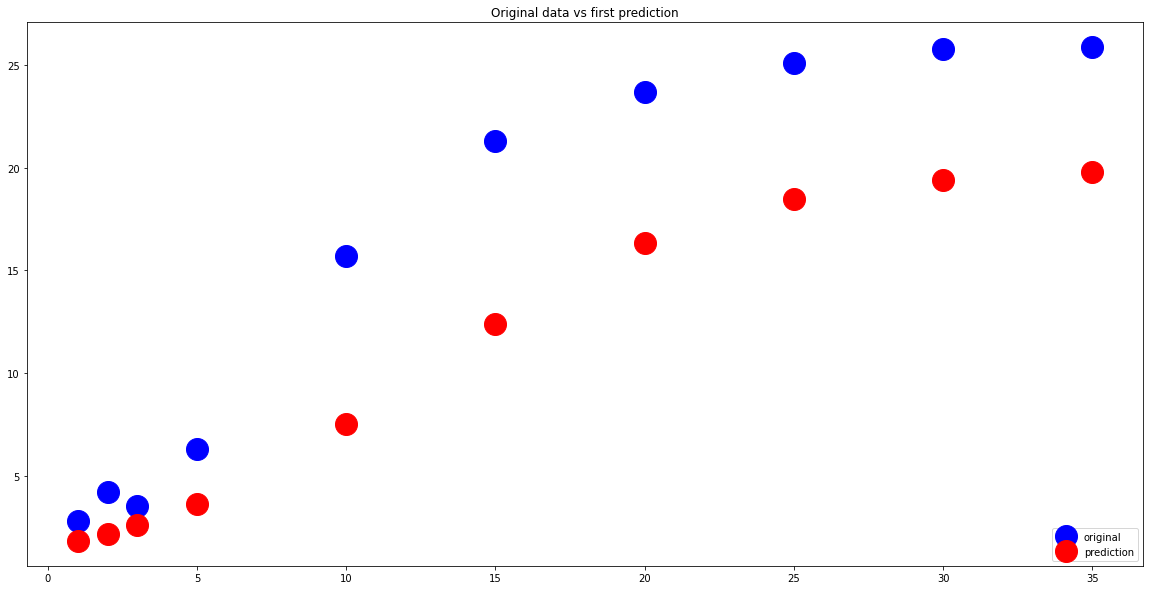

In [19]:
y_bar = eval_logistic(coeffs, np.array(Year))

plt.figure(figsize=(20,10))
plt.plot(Year, Population, 'bo', label = 'original',markersize=22)
plt.plot(Year, y_bar, 'ro', label='prediction',markersize=22)
plt.title('Original data vs first prediction')
plt.legend(loc="lower right")
plt.show()

It is evident from the above plot that this new model with random coefficients does not fit our data all that well. To get a quantifiable measure of how incorrect it is, we calculate the Squared Error loss for the model. This is the sum of the squared differences between the actual and predicted outputs:
$$E=\sum_{i=1}^n(y_i-\bar{y_i})^2,$$
where $y_i$ is the actual value and $\bar{y_i}$ is the predicted value.

In [20]:
def loss_mse(y_real, y_bar):
    return sum((y_real - y_bar)*(y_real - y_bar))
  
initial_model_loss = loss_mse(Population, y_bar)
  
initial_model_loss

336.88508278005713

##Gradient Descent and Loss Reduction
We wish to improve our model, that is, we want to alter its coefficients $P_0, K$ and $r$ to decrease the error. Therefore we require knowledge about how each coefficient affects the error. This is achieved by calculating the partial derivative of the error function with respect to each of the individual coefficients.

In this case, we are using LSE as our error function — this is the function we wish to calculate partial derivatives for:
$$E=\sum_{i=1}^n(y_i-\bar{y_i})^2$$
With output predictions for our model as:
$$\bar{y}=\frac{P_0Ke^{rt}}{(K-P_0)+P_0e^{rt}}$$
Error function can therefore be reformulated as:
$$E=\sum_{i=1}^n\left(y_i-\frac{P_0Ke^{rt}}{(K-P_0)+P_0e^{rt}}\right)^2$$

In this specific case, our partial derivatives for that loss function are the following:

* Partial derivative with respect to $P_0$:
$$\frac{dE}{dP_0}=-2\sum_{i=1}^n\left[\left(y_i-\frac{P_0Ke^{rt}}{(K-P_0)+P_0e^{rt}}\right)\frac{\partial}{\partial P_0}\left(\frac{P_0Ke^{rt}}{(K-P_0)+P_0e^{rt}}\right)\right]\\
=-2\sum_{i=1}^n\left[\left(y_i-\frac{P_0Ke^{rt}}{(K-P_0)+P_0e^{rt}}\right)\left(\frac{K^2e^{rt}}{[(K-P_0)+P_0e^{rt}]^2}\right)\right]$$

* Partial derivative with respect to $K$:
$$\frac{dE}{dK}=-2\sum_{i=1}^n\left[\left(y_i-\frac{P_0Ke^{rt}}{(K-P_0)+P_0e^{rt}}\right)\frac{\partial}{\partial K}\left(\frac{P_0Ke^{rt}}{(K-P_0)+P_0e^{rt}}\right)\right]\\
=-2\sum_{i=1}^n\left[\left(y_i-\frac{P_0Ke^{rt}}{(K-P_0)+P_0e^{rt}}\right)\left(\frac{P_0^2e^{rt}(e^{rt}-1)}{[(K-P_0)+P_0e^{rt}]^2}\right)\right]$$

* Partial derivative with respect to $r$:
$$\frac{dE}{dr}=-2\sum_{i=1}^n\left[\left(y_i-\frac{P_0Ke^{rt}}{(K-P_0)+P_0e^{rt}}\right)\frac{\partial}{\partial r}\left(\frac{P_0Ke^{rt}}{(K-P_0)+P_0e^{rt}}\right)\right]\\
=-2\sum_{i=1}^n\left[\left(y_i-\frac{P_0Ke^{rt}}{(K-P_0)+P_0e^{rt}}\right)\left(\frac{K-P_0}{[(K-P_0)+P_0e^{rt}]^2}\right)\right]$$

##Get that loss down
We need a gradient calculation function which, given a logistic growth model's coefficients, as well as a set of inputs $𝑥$ and a corresponding set of actual outputs $𝑦$ will return the respective gradients for each coefficient.

In [72]:
def calc_gradient(coeffs, x_real, y_real): 
      
    P0_s = []
    K_s = []
    r_s = []
    
    
    y_bars = eval_logistic(coeffs, x_real)
    
    for x,y,y_bar in list(zip(x_real, y_real, y_bars)):    # take tuple of (x datapoint, actual y label, predicted y label)
            
            partial_P0 = (coeffs[1]**2*np.exp(coeffs[2]*x)/(coeffs[1]-coeffs[0]+coeffs[0]*np.exp(coeffs[2]*x))**2)*(y-y_bar)
            P0_s.append(partial_P0)
            partial_K =  (coeffs[0]**2*np.exp(coeffs[2]*x)*(np.exp(coeffs[2]*x)-1)/(coeffs[1]-coeffs[0]+coeffs[0]*np.exp(coeffs[2]*x))**2)*(y-y_bar)
            K_s.append(partial_K)
            partial_r =  ((coeffs[1]-coeffs[0])/(coeffs[1]-coeffs[0]+coeffs[0]*np.exp(coeffs[2]*x))**2)*(y-y_bar)
            r_s.append(partial_r)
        
    gradient_P0 = -2 * sum(P0_s)
    gradient_K = -2 * sum(K_s)
    gradient_r = -2 * sum(r_s)
    return(gradient_P0, gradient_K, gradient_r)   # return calculated gradients as a a tuple of its 3 parts


We’re now going to:

* Use the above function to calculate gradients for our first guess,
* Adjust the model’s coefficients accordingly,
* Verify that the model’s loss is now smaller — that G.D. has worked!

Let’s set an initial learning rate to experiment with. This should be kept small to avoid the missing the global minimum, but not so small that it takes forever or gets stuck in a local minimum. $lr = 0.0001$ is a good place to start.

In [91]:
calc_grad = calc_gradient(coeffs, np.array(Year), np.array(Population))

lr = 0.0001
P0_new = coeffs[0] - lr * calc_grad[0]
K_new = coeffs[1] - lr * calc_grad[1]
r_new = coeffs[2] - lr * calc_grad[2]

new_model_coeffs = (P0_new, K_new, r_new)
print(f"New model coeffs: {new_model_coeffs}")
print("")

#update with these new coeffs:
new_y_bar = eval_logistic(new_model_coeffs, np.array(Year))
updated_model_loss = loss_mse(np.array(Population), new_y_bar)

print(f"Now have smaller model loss: {updated_model_loss} vs {initial_model_loss}")

New model coeffs: (1.5191251324176007, 20.005349023031577, 0.2001054431545341)

Now have smaller model loss: 332.58239633005684 vs 336.88508278005713


Visualize this improvement by plotting the training data, original random model and updated lower-loss model together:

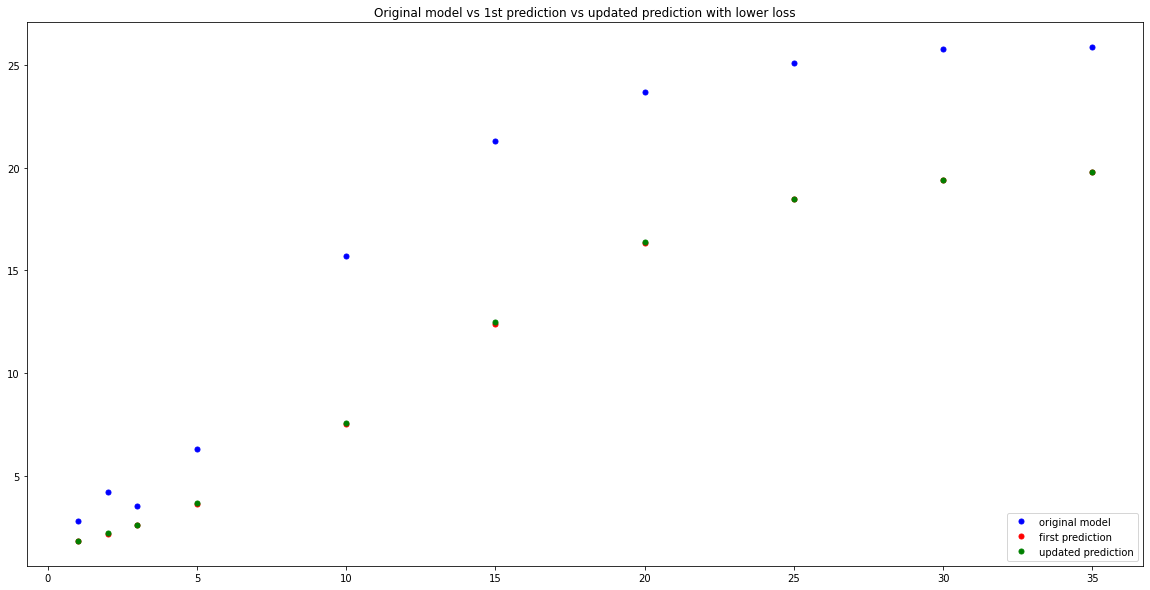

In [92]:
plt.figure(figsize=(20,10))
plt.plot(Year, Population, 'bo', label = 'original model',markersize=5)
plt.plot(Year, y_bar, 'ro', label = 'first prediction',markersize=5)
plt.plot(Year, new_y_bar, 'go', label = 'updated prediction',markersize=5)
plt.title('Original model vs 1st prediction vs updated prediction with lower loss')
plt.legend(loc="lower right")
plt.show()

##Iterative Gradient Descent over many epochs
We’re almost ready. The last step will be to perform gradient descent iteratively over a number of epochs (cycles or iterations.) With every epoch we hope to see an improvement in the form of lowered loss, and better model-fitting to the original data.

Let’s improve on the calc_gradient_2nd_poly function from above, to make it more usable for an iterative gradient descent process:

In [93]:
def calc_gradient_for_GD(coeffs, inputs_x, outputs_y, lr): 
    P0_s = []
    K_s = []
    r_s = []
        
    y_bars = eval_logistic(coeffs, inputs_x)

    for x,y,y_bar in list(zip(inputs_x, outputs_y, y_bars)):    # take tuple of (x datapoint, actual y label, predicted y label)
        partial_P0 = (coeffs[1]**2*np.exp(coeffs[2]*x)/(coeffs[1]-coeffs[0]+coeffs[0]*np.exp(coeffs[2]*x))**2)*(y-y_bar)
        P0_s.append(partial_P0)
        partial_K =  (coeffs[0]**2*np.exp(coeffs[2]*x)*(np.exp(coeffs[2]*x)-1)/(coeffs[1]-coeffs[0]+coeffs[0]*np.exp(coeffs[2]*x))**2)*(y-y_bar)
        K_s.append(partial_K)
        partial_r =  ((coeffs[1]-coeffs[0])/(coeffs[1]-coeffs[0]+coeffs[0]*np.exp(coeffs[2]*x))**2)*(y-y_bar)
        r_s.append(partial_r)
    
    gradient_P0 = -2 * sum(P0_s)
    gradient_K = -2 * sum(K_s)
    gradient_r = -2 * sum(r_s)

    P0_new = coeffs[0] - lr * gradient_P0
    K_new = coeffs[1] - lr * gradient_K
    r_new = coeffs[2] - lr * gradient_r
    
    new_model_coeffs = (P0_new, K_new, r_new)
    #print(new_model_coeffs)
    #update with these new coeffs:
    new_y_bar = eval_logistic(new_model_coeffs, inputs_x)
    
    updated_model_loss = loss_mse(outputs_y, new_y_bar)
    #print(updated_model_loss)
    return updated_model_loss, new_model_coeffs, new_y_bar
    

This will be called as part of the gradient_descent function:



In [94]:
def gradient_descent(epochs, lr):
    losses = []
    rand_coeffs_to_test = coeffs
    for i in range(epochs):
        loss = calc_gradient_for_GD(rand_coeffs_to_test, np.array(Year), np.array(Population), lr)
        rand_coeffs_to_test = loss[1]
        losses.append(loss[0])
    print(losses)
    return loss[0], loss[1], loss[2], losses  #(updated_model_loss, new_model_coeffs, new_y_bar, saved loss updates)


Finally, let’s train for 10000 epochs and see if our model has learned anything:



[332.58239633005684, 328.45060931509033, 324.4783232767843, 320.6552008821471, 316.97184003681866, 313.41966600534204, 309.9908385445632, 306.6781716201195, 303.4750637218047, 300.37543714846373, 297.37368491731195, 294.4646241816111, 291.64345522621755, 288.905725261719, 286.24729636167007, 283.66431698930063, 281.15319664425925, 278.7105832298572, 276.3333427995433, 274.01854139012323, 271.7634286902153, 269.56542332699627, 267.4220995835403, 265.33117538389433, 263.2905014041834, 261.29805118612444, 259.35191214483035, 257.4502773760892, 255.59143817980498, 253.77377722619514, 251.9957622999447, 250.25594056498392, 248.55293329906056, 246.8854310529529, 245.25218919412953, 243.6520237990276, 242.08380786192387, 240.5464677917571, 239.03898017121628, 237.56036875503423, 236.10970168675232, 234.68608891527444, 233.28867979436203, 231.9166608498469, 230.56925370079594, 229.24571312214744, 227.94532523750465, 226.66740583181024, 225.41129877454978, 224.17637454497213, 222.96202885157084

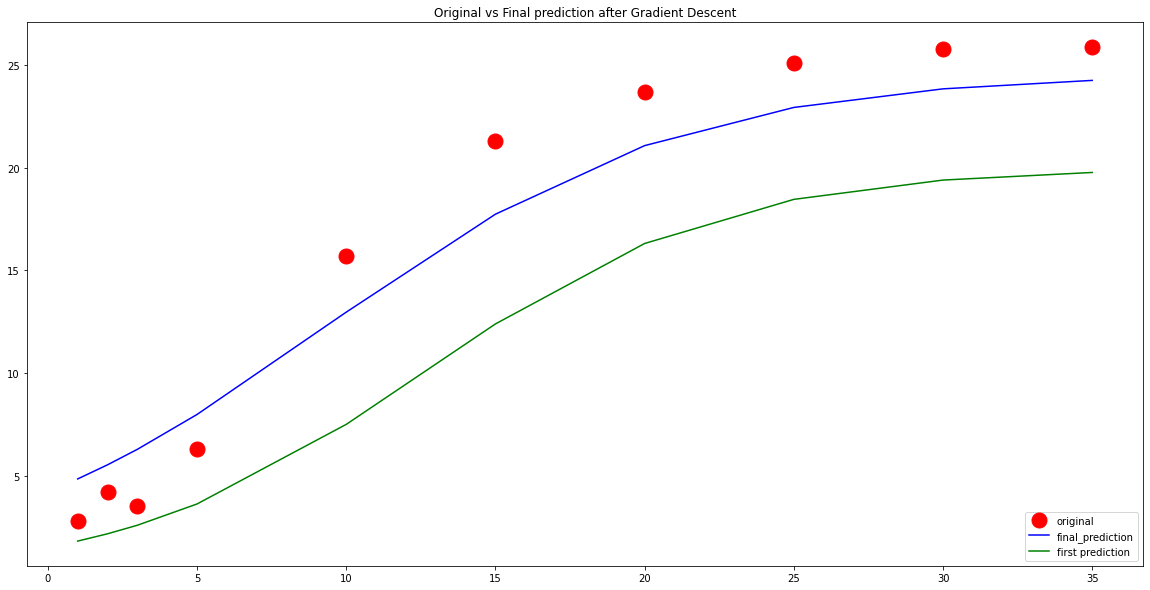

In [104]:
GD = gradient_descent(1500, 0.0001)

plt.figure(figsize=(20,10))
plt.plot(Year, Population, 'ro', label = 'original',markersize=15)
plt.plot(Year, GD[2], 'b-', label = 'final_prediction',markersize=15)
plt.plot(Year, y_bar, 'g-', label = 'first prediction',markersize=5)
plt.title('Original vs Final prediction after Gradient Descent')
plt.legend(loc="lower right")
plt.show()

In [102]:
print(f"Final Coefficients predicted: {GD[1]}")
print(f"Original Coefficients: {coeffs}")

Final Coefficients predicted: (5.740480137620619, 26.947426576718826, 0.11277377167078236)
Original Coefficients: [1.5, 20, 0.2]


Not too far off! A big improvement over the initial random model. Looking at the plot of the loss reduction over training offers further insights:

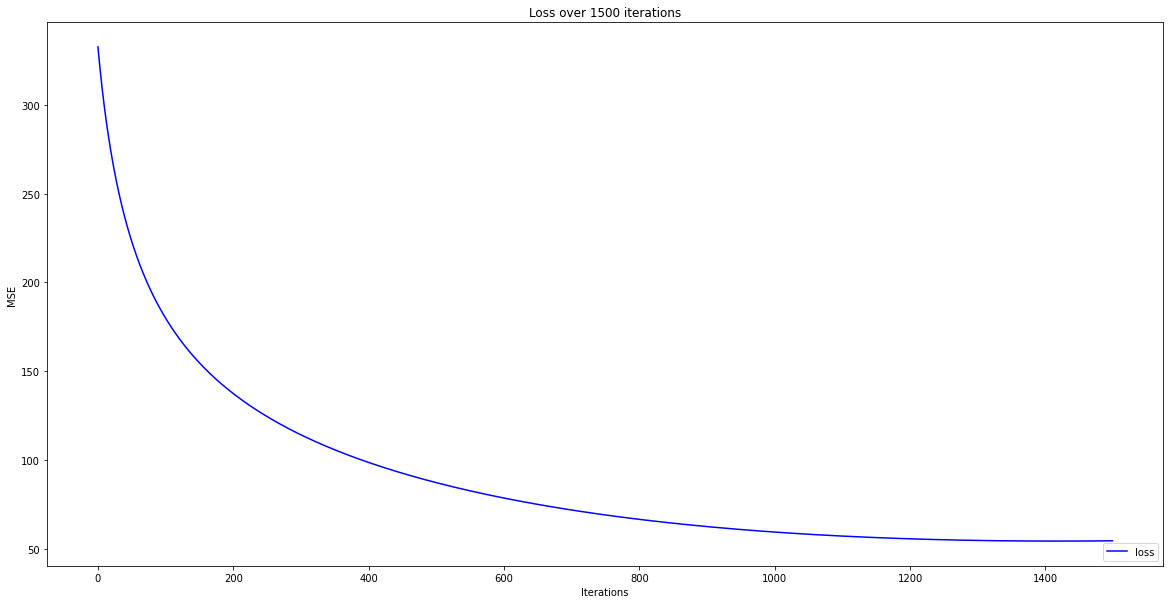

In [105]:
plt.figure(figsize=(20,10))
plt.plot(GD[3], 'b-', label = 'loss')
plt.title('Loss over 1500 iterations')
plt.legend(loc="lower right")
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.show()

## Compare with the coefficients obtained using the built-in function
Now we revisit the buit-in function to compare the values with the values we got using Gradient Descent.


In [106]:
from scipy.optimize import curve_fit

def logistic(t, P0 ,K, r):
    y = (P0*K*np.exp(r*t))/((K-P0)+P0*np.exp(r*t))
    return (y)

p0 = [min(Population), max(Population), 0.3] # this is an mandatory initial guess

popt, pcov = curve_fit(logistic, Year, Population, p0, method='dogbox')
popt

array([ 2.11585892, 25.50289437,  0.2750776 ])

In [107]:
GD[1]

(4.21160215563491, 24.588651861520454, 0.16859717217827283)

In [108]:
popt-GD[1]

array([-2.09574323,  0.91424251,  0.10648043])